# Calculate Compound Years for CESM

This file grabs the warm season indeces and sees if this shows us anything


You need to run cesmIndeces.ipnyb first

In [1]:
#For plots of a single experiment to demonstrate things, plot this one:

expToPlot = 'LME.002'

In [37]:
#import my functions
import utils._modelDefinitions as _model
import utils._indexDefinitions as _index
from utils.timePeriod import averageForTimePeriod

%run 'utils/compound.ipynb'

In [3]:
import xarray
import matplotlib.pyplot as plt
import numpy
import pandas

%matplotlib inline

In [4]:
# Here is the data
indecesDa = xarray.load_dataarray('results/cesmTradIndeces.nc')

indecesDa.experiment.values

array(['LME.002', 'LME.003', 'LME.008', 'LME.009', '001', '002', '003',
       '004', '005', '006', '007', '008', '009', '010', '011', '012',
       '013'], dtype=object)

# Define a criteria to determine events, and plot an example

So we are going to define events as follows:
- For SST indeces (aka Enso and Iod), this is 1 sigma above/below mean
- For PSL indeces (aka Sam) this is 0.5 sigma above/below mean

For now, using a 850-1850 climatology

In [5]:
# This should calculate stds for all experiments and all indeces
stdDa = indecesDa.std(dim='year')

# define some criteria that we want to use to identifiy it thats an event
criteriaDa = xarray.concat(
    (stdDa.sel(index=['nino34','dmi']), stdDa.sel(index='sam')/2),
    'index'
)

# Calculate the compounding years and plot an example

In [38]:
firePos, fireNeg = applyCriteria(indecesDa, criteriaDa)

firePos=compound(firePos)

fireNeg=compound(fireNeg)

In [41]:
firePos.attrs

{'pairs': ['nino34+dmi', 'nino34+sam', 'dmi+sam']}

In [42]:
firePos.index.values

array(['nino34', 'dmi', 'sam', 'count', 'all3', 'nino34+dmi',
       'nino34+sam', 'dmi+sam'], dtype='<U10')

In [50]:
firePos.attrs['pairs']

['nino34+dmi', 'nino34+sam', 'dmi+sam']

Text(0.5, 1.0, 'LME.002: Pairs and all-three compounds for individal years')

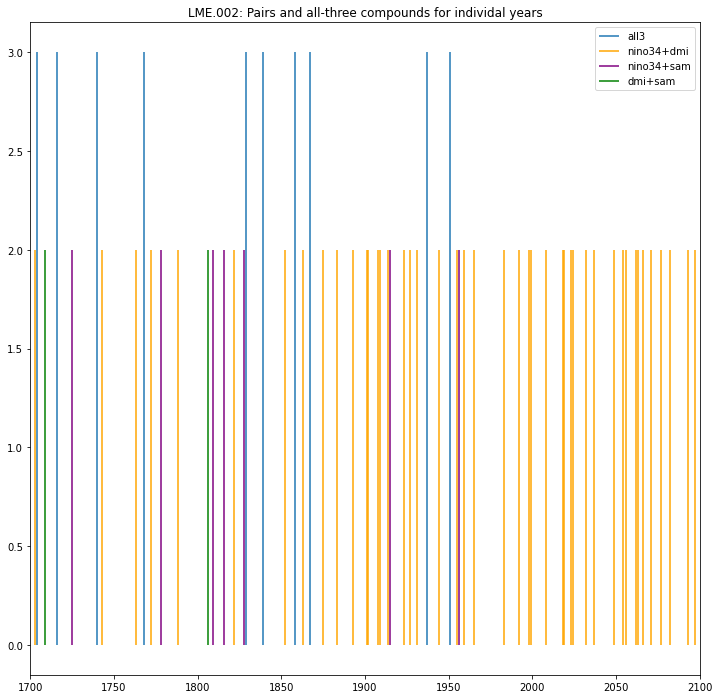

In [162]:

toPlot=3*firePos.sel(experiment=expToPlot, index='all3')

plt.figure(figsize=(12,12))

plt.vlines(
    x=firePos.year, 
    ymin=0,
    ymax=toPlot,
    label='all3'
)

colors=['orange', 'purple', 'green']
iCol = 0

for iPair in firePos.attrs['pairs']:
    plt.vlines(
        x=firePos.year, 
        ymin=0,
        ymax=2*firePos.sel(experiment=expToPlot, index=iPair),
        color=colors[iCol],
        label=iPair
    )
    iCol+=1
plt.legend()
plt.xlim(1700,2100)
plt.title(expToPlot+': Pairs and all-three compounds for individal years')

# In 30 year bins

In [57]:
#binsL=(numpy.arange(850,2110,10))

#binsMid=(binsL[:-3]+binsL[3:])/2

#yearBins=numpy.array(list(zip(binsL[:-3], binsL[3:])))

yearBins=numpy.arange(870, 2130, 30)

In [58]:
binnedFirePos=firePos.groupby_bins('year', yearBins).sum() 


In [60]:
#stupidly complicated way to figure out the mid points of my bins?
x = pandas.IntervalIndex(binnedFirePos.year_bins.values).mid

Text(0.5, 1.0, 'Mean number of pairs and all-three for four runs with Rcp85, in non-overlapiing 30 year bins')

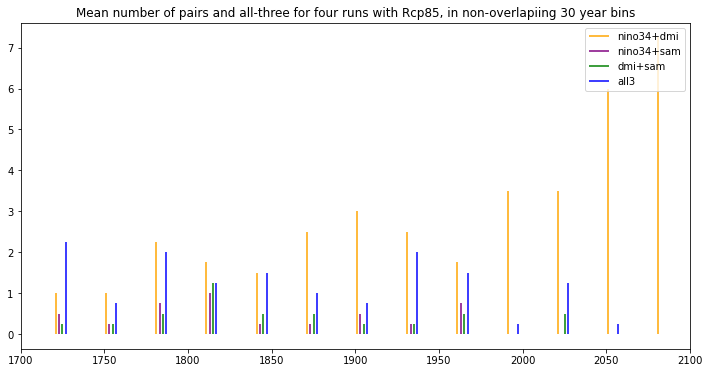

In [165]:
toPlot=binnedFirePos.sel(experiment=expToPlot, index='all3')

plt.figure(figsize=(12,6))


pairs=firePos.attrs['pairs']
toPlot=[*pairs,'all3']
colors=['orange', 'purple', 'green','blue']

for counter in [0,1,2,3]:
    plt.vlines(
        x=x-4+2*counter, 
        ymin=0,
        ymax=binnedFirePos.sel(index=toPlot[counter], experiment=_model.cesmRcp85).mean(dim='experiment'),
        label=toPlot[counter],
        color=colors[counter]
    )
    
plt.legend()
plt.xlim(1700,2100)
plt.title('Mean number of pairs and all-three for runs with Rcp85, in non-overlaping 30 year bins')